# Univariate models

In [2]:
import pandas as pd
import pandas_datareader.data as web
import quandl
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')
pd.options.display.max_columns = 999
pd.options.display.max_rows = 9999


series_list = ['DCOILWTICO']
start = datetime(2000, 1, 1)
end = datetime.now()

def get_fred_data(series_list, start, end):
    fred_df = pd.DataFrame()
    for i, series in enumerate(series_list):
        print('Calling FRED API for Series:  {}'.format(series))
        if i == 0:
            fred_df = web.get_data_fred(series, start, end)
        else:
            _df = web.get_data_fred(series, start, end)
            fred_df = fred_df.join(_df, how='outer')
    return fred_df

econ_df = get_fred_data(series_list, start, end)
econ_df.tail(100)
econ_df.head(10)

econ_df.dropna(inplace=True)

Calling FRED API for Series:  DCOILWTICO


In [3]:
len(econ_df)

6125

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns

Text(0.5, 1.0, 'Box Plot Year Wise-WTI')

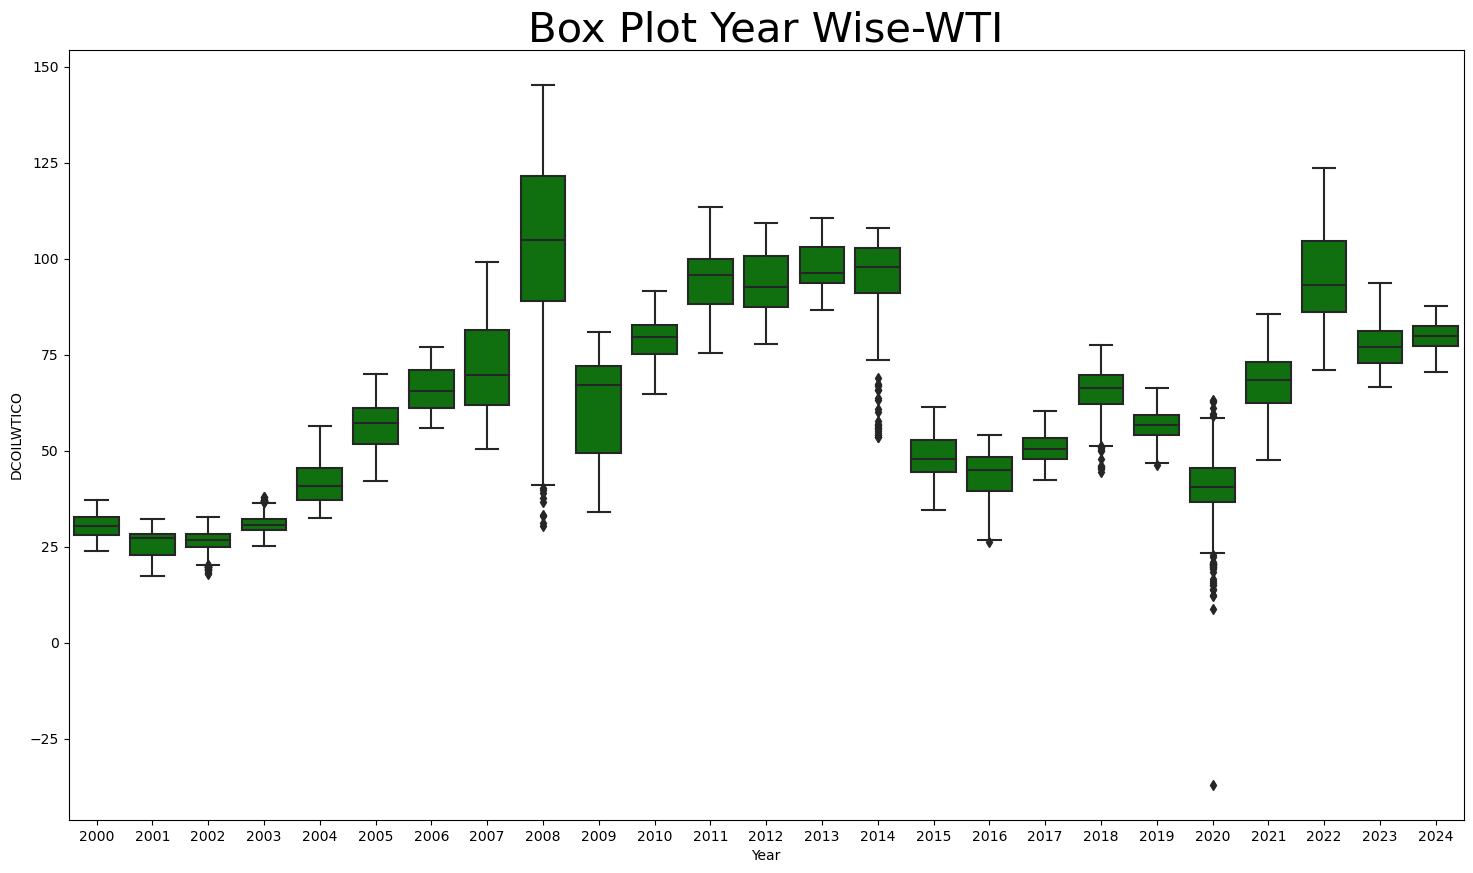

In [5]:
##Box Plot Year Wise WTI
econ_df_1 = econ_df.copy()
econ_df_1['Year'] = econ_df_1.index.year
plt.figure(figsize=(18,10))
ax = sns.boxplot(x=econ_df_1['Year'], y=econ_df_1['DCOILWTICO'], color='green')
ax.set_title('Box Plot Year Wise-WTI',fontsize=30)

In [6]:
econ_df.index

DatetimeIndex(['2000-01-04', '2000-01-05', '2000-01-06', '2000-01-07',
               '2000-01-10', '2000-01-11', '2000-01-12', '2000-01-13',
               '2000-01-14', '2000-01-18',
               ...
               '2024-05-16', '2024-05-17', '2024-05-20', '2024-05-21',
               '2024-05-22', '2024-05-23', '2024-05-24', '2024-05-28',
               '2024-05-29', '2024-05-30'],
              dtype='datetime64[ns]', name='DATE', length=6125, freq=None)

Interesting insights: huge dispersion in 2008 crisis, for 2020 (Covid), and for 2022 (Russian operation in Ukraine)
Years 2002, 2008, 2014, 2018, 2020, 2022 show outliers.
    

We take data from 2010
From 2007 to 2009 there was a huge fifnancial crisis, so I have taken data from 2010
We need to overcome problem with outliers in 2020 , 2018 and so on

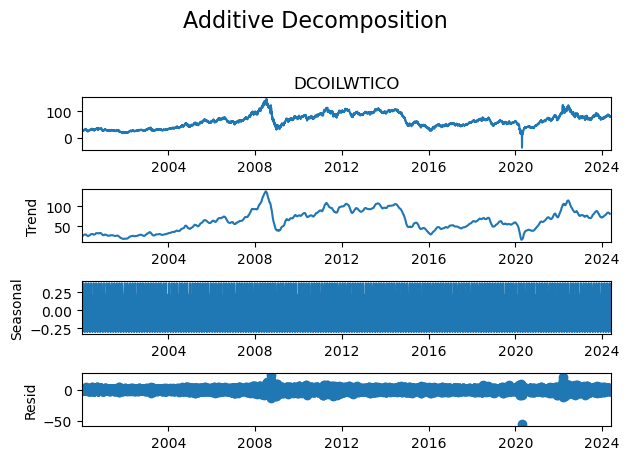

In [7]:
from statsmodels.tsa.seasonal import seasonal_decompose
from dateutil.parser import parse


# Additive Decomposition
additive_decomposition = seasonal_decompose(econ_df['DCOILWTICO'], model='additive', period=30)


additive_decomposition.plot().suptitle('Additive Decomposition', fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])

plt.show()

Some insights: from data analysis we can see that before each crisis (in 2008, in 2020) there was an upward trend but after that 
prices go down and then again there is a precence of upward trend

In [8]:
import pandas as pd
from statsmodels.tsa.stattools import adfuller


# Perform the ADF test
result = adfuller(econ_df['DCOILWTICO'])

# Print the p-value
print('ADF Statistic:', result[0])
print('p-value:', result[1])
#statistically insignificant

ADF Statistic: -2.691288128823318
p-value: 0.07555797386394836


The problem with trended data (especially inflation-affected financial asset data, which tends to grow exponentially 
with inflation) is that it smashes early data into oblivion, making it nearly invisible to the model 
trying to generalize something from it.
Source: https://medium.com/@john.kosinski/preparing-and-shaping-timeseries-data-for-keras-lstm-input-part-one-5bb882bc2143

<Axes: title={'center': 'Percentage change of WTI crude oil price'}, xlabel='DATE'>

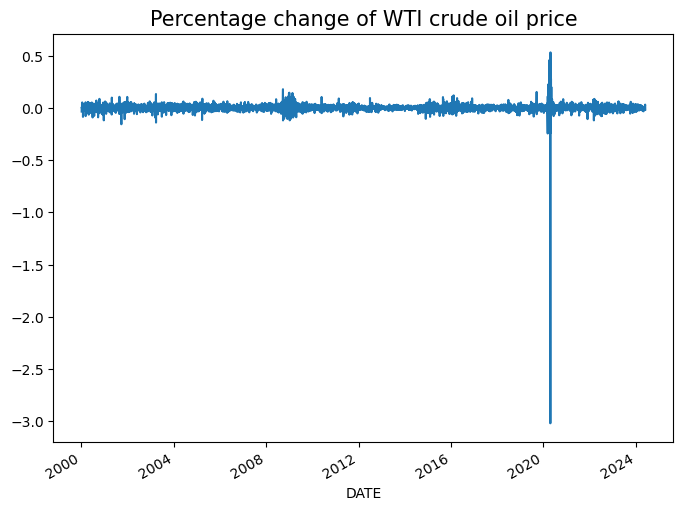

In [9]:
econ_df['Change'] = econ_df['DCOILWTICO'].pct_change()
fig, ax = plt.subplots(figsize=(8, 6))
ax.set_title('Percentage change of WTI crude oil price', fontsize=15)
econ_df['Change'].plot()

In [10]:
econ_df = econ_df. tail(-1) 

In [11]:

#Builing of model"
del econ_df['Change']

In [12]:
def mahalanobis(x=None, data=None, cov=None):
    """Compute the Mahalanobis Distance between each row of x and the data  
    x    : vector or matrix of data with, say, p columns.
    data : ndarray of the distribution from which Mahalanobis distance of each observation of x is to be computed.
    cov  : covariance matrix (p x p) of the distribution. If None, will be computed from data.
    """
    x_minus_mu = x - np.mean(data)
    if not cov:
        cov = np.cov(data.values.T)
    inv_covmat = scipy_linalg.inv(cov)
    left_term = np.dot(x_minus_mu, inv_covmat)
    mahal = np.dot(left_term, x_minus_mu.T)
    return mahal.diagonal()


In [13]:
import numpy as np
from scipy import linalg as scipy_linalg
mah_df = econ_df.copy()
mah_df['Mahalanobis'] = mahalanobis(x=mah_df, data=mah_df)
mah_df.head(3)

ValueError: expected square matrix

In [14]:
sns.distplot(mah_df['Mahalanobis'])

KeyError: 'Mahalanobis'

In [ ]:
import pandas as pd
econ_df_multivariate = pd.read_csv('econ_df_1')
econ_df_multivariate.dropna(subset = ['WTI'], inplace=True)
econ_df_multivariate.interpolate(inplace=True)
econ_df_multivariate.drop(['Bitcoin', 'S&P500', 'Dow Jones', 'US_CPI:energy:', 'EU PPI', 'US_PPI:total'], axis=1, inplace=True)
econ_df_multivariate.drop(['Gold'], axis=1, inplace=True)
econ_df_multivariate.dropna(inplace=True)
econ_df = econ_df_multivariate['WTI']
econ_df.index = econ_df_multivariate['Date']

econ_df = pd.DataFrame(econ_df)

In [ ]:
from scipy.stats import zscore as zs

zscore = np.abs(zs(econ_df))
zscore_df = econ_df.copy()
zscore_df['zscore'] = zscore
zscore_df.head(5)

In [ ]:
len(zscore_df[zscore_df['zscore']>2])

In [ ]:
zscore_df = zscore_df.loc[zscore_df['zscore']<2]
zscore_df.shape
del zscore_df['zscore']
econ_df = zscore_df

In [ ]:
econ_df.shape

# Vanilla LSTM model

In [15]:

# normalize the data_set 
from sklearn.preprocessing import MinMaxScaler
scaler_test = MinMaxScaler(feature_range = (0, 1))
scaler_val = MinMaxScaler(feature_range = (0, 1))
scaler_train = MinMaxScaler(feature_range = (0, 1))

In [16]:
#Train-validation-test split
train_size = int(len(econ_df) * 0.70)
validation_size = int(len(econ_df) * 0.20)
test_size = len(econ_df) - train_size - validation_size
train, validation, test = econ_df[0:train_size], econ_df[train_size:train_size+validation_size], econ_df[train_size+validation_size:len(econ_df)]


train_sc = scaler_train.fit_transform(train.values)
test_sc = scaler_test.fit_transform(test.values)
validation_sc = scaler_val.fit_transform(validation.values)

In [17]:
#preparation of dataset
def create_data_set(_data_set, _look_back):
    data_x, data_y = [], []
    for i in range(len(_data_set) - _look_back - 1):
        a = _data_set[i:(i + _look_back), 0]
        data_x.append(a)
        data_y.append(_data_set[i + _look_back, 0])
    return np.array(data_x), np.array(data_y)

In [18]:
look_back = 5
X_train,Y_train,X_test,Ytest, Xval, Yval = [],[],[],[],[], []

X_train,Y_train=create_data_set(train_sc,look_back)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
Y_train = Y_train.reshape(-1, 1)
print(X_train.shape, Y_train.shape)

X_test,Y_test=create_data_set(test_sc,look_back)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
Y_test = Y_test.reshape(-1, 1)
print(X_test.shape, Y_test.shape)

X_val,Y_val=create_data_set(validation_sc,look_back)
X_val = np.reshape(X_val, (X_val.shape[0], X_val.shape[1], 1))
Y_val = Y_val.reshape(-1, 1)
print(X_val.shape, Y_val.shape)

(4280, 5, 1) (4280, 1)
(608, 5, 1) (608, 1)
(1218, 5, 1) (1218, 1)


In [19]:
X_test

array([[[0.10047344],
        [0.07574961],
        [0.03647203],
        [0.07873049],
        [0.10889006]],

       [[0.07574961],
        [0.03647203],
        [0.07873049],
        [0.10889006],
        [0.12765211]],

       [[0.03647203],
        [0.07873049],
        [0.10889006],
        [0.12765211],
        [0.15570752]],

       ...,

       [[0.26389619],
        [0.25916184],
        [0.24636156],
        [0.21988427],
        [0.19042609]],

       [[0.25916184],
        [0.24636156],
        [0.21988427],
        [0.19042609],
        [0.20813607]],

       [[0.24636156],
        [0.21988427],
        [0.19042609],
        [0.20813607],
        [0.25056988]]])

In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import datetime
from pylab import rcParams
import matplotlib.pyplot as plt
import warnings
import itertools
import statsmodels.api as sm
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from sklearn.metrics import mean_squared_error
from keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import seaborn as sns

from tensorflow.keras import layers

regressor = Sequential()

regressor.add(LSTM(units = 60, return_sequences=True,input_shape=(X_train.shape[1], 1), activation='tanh'))
regressor.add(Dropout(0.05))


regressor.add(LSTM(units = 60, return_sequences = True, activation='tanh'))
regressor.add(Dropout(0.05))


regressor.add(Dense(units = 1))


regressor.compile(optimizer = 'Adam', loss = 'mean_squared_error')

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=50)
history_simple = regressor.fit(X_train, Y_train, validation_data=(X_val, Y_val), epochs = 100, batch_size = 15, shuffle=False, callbacks = [es])

loss=history_simple.history['loss']
val_loss = history_simple.history['val_loss']

epochs=range(len(loss)) # Get number of epochs
# Plot training and validation loss per epoch
plt.plot(epochs, loss, 'r',label='loss')
plt.plot(epochs,val_loss,'blue',label='val loss')
plt.title('Training loss & Val Loss by Epochs')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

plt.figure()
     

In [ ]:
X_train.shape
X_val.shape

In [ ]:
val_predictions = regressor.predict(X_val)
val_predictions.shape


In [ ]:
val_predictions[:,0].shape

In [ ]:
Y_val_reverse = scaler_test.inverse_transform(Y_val)
Y_val_reverse.shape

In [ ]:
def get_predictions_val(X_val):
    
    val_predictions = regressor.predict(X_val)
    val_predictions = scaler_val.inverse_transform(val_predictions[:, 0]).flatten()
    Y_val_reverse = scaler_val.inverse_transform(Y_val).flatten()
    global val_results
    val_results = pd.DataFrame(data={ 'Val Predictions':val_predictions, 'Actuals':Y_val_reverse})
    return val_results

get_predictions_val(X_val).head(10)


In [ ]:
def result_metrics_forecast(test_series,forecast_series,model_name):
  print('Result Metrics for ' +  str(model_name))
  print('R2 Score : ',round(r2_score(test_series,forecast_series),3))
  print('Mean Squared Error : ',round(mean_squared_error(test_series,forecast_series),3))
  print('Mean Absolute Error : ',round(mean_absolute_error(test_series,forecast_series),3))
  fig = plt.figure(figsize=(8,5))
  plt.plot(test_series,label='Actual')
  plt.plot(forecast_series,label='Predicted')
  plt.title(str(model_name))
  plt.ylabel('Price')
  plt.legend()
     

In [ ]:
result_metrics_forecast(val_results['Actuals'], val_results['Val Predictions'],'Vanilla LSTM for validation data')

esult Metrics for Vanilla LSTM  (Initial score, epochs = 20, 2 layers)  
R2 Score :  0.663  
Mean Squared Error :  31.364  
Mean Absolute Error :  4.534  


Result Metrics for Vanilla LSTM  (epochs = 20, layers = 1)   

R2 Score :  0.757  
Mean Squared Error :  22.608  
Mean Absolute Error :  4.017  

Result Metrics for Vanilla LSTM (tahnh activation)   
R2 Score :  0.816  
Mean Squared Error :  17.12  
Mean Absolute Error :  3.461  



Result Metrics for Vanilla LSTM  (relu)  
R2 Score :  0.757  
Mean Squared Error :  22.608  
Mean Absolute Error :  4.017  

Result Metrics for Vanilla LSTM for validation data (adam)  
R2 Score :  0.816  
Mean Squared Error :  17.12  
Mean Absolute Error :  3.461  

Result Metrics for Vanilla LSTM  (sgd)  
R2 Score :  -1.365  
Mean Squared Error :  220.002  
Mean Absolute Error :  12.953  


Result Metrics for Vanilla LSTM (rms prop)    
R2 Score :  0.678  
Mean Squared Error :  29.956  
Mean Absolute Error :  4.845  




Dropout 0.01  

Result Metrics for Vanilla LSTM for validation data
R2 Score :  0.723
Mean Squared Error :  25.775
Mean Absolute Error :  4.459


Dropout 0.05
R2 Score :  0.816
Mean Squared Error :  17.12
Mean Absolute Error :  3.461



Dropout 0.1 
R2 Score :  0.723
Mean Squared Error :  25.775
Mean Absolute Error :  4.459


Batch Normalisation

R2 Score :  0.81
Mean Squared Error :  17.652
Mean Absolute Error :  3.522


Result Metrics for Vanilla LSTM for validation data
R2 Score :  0.655
Mean Squared Error :  32.08
Mean Absolute Error :  5.021


Result Metrics for Vanilla LSTM (epochs = 100)
R2 Score :  0.89
Mean Squared Error :  10.198
Mean Absolute Error :  2.576



Result Metrics for Vanilla LSTM for validation data (window size = 25)
R2 Score :  0.534
Mean Squared Error :  43.778
Mean Absolute Error :  5.515

In [502]:
def get_predictions(X_test):
    
    test_predictions = regressor.predict(X_test)
    test_predictions = scaler_test.inverse_transform(test_predictions[:,0]).flatten()
    Y_test_reverse = scaler_test.inverse_transform(Y_test).flatten()
    global test_results
    test_results = pd.DataFrame(data={ 'Test Predictions':test_predictions, 'Actuals':Y_test_reverse})
    return test_results

get_predictions(X_test).head(10)

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


,Test Predictions,Actuals
0,77.638016,79.47
1,76.372368,79.00
2,76.926743,78.11
3,77.782707,81.17
4,78.492577,82.51
5,79.910683,81.97
6,79.502304,83.82
7,78.733284,85.42
8,81.399521,86.84
9,82.584251,86.29


In [503]:
def result_metrics_forecast(test_series,forecast_series,model_name):
  print('Result Metrics for ' +  str(model_name))
  print('R2 Score : ',round(r2_score(test_series,forecast_series),3))
  print('Mean Squared Error : ',round(mean_squared_error(test_series,forecast_series),3))
  print('Mean Absolute Error : ',round(mean_absolute_error(test_series,forecast_series),3))
  fig = plt.figure(figsize=(8,5))
  plt.plot(test_series,label='Actual')
  plt.plot(forecast_series,label='Predicted')
  plt.title(str(model_name))
  plt.ylabel('Price')
  plt.legend()
     

Result Metrics for Vanilla LSTM
R2 Score :  0.842
Mean Squared Error :  19.414
Mean Absolute Error :  3.253


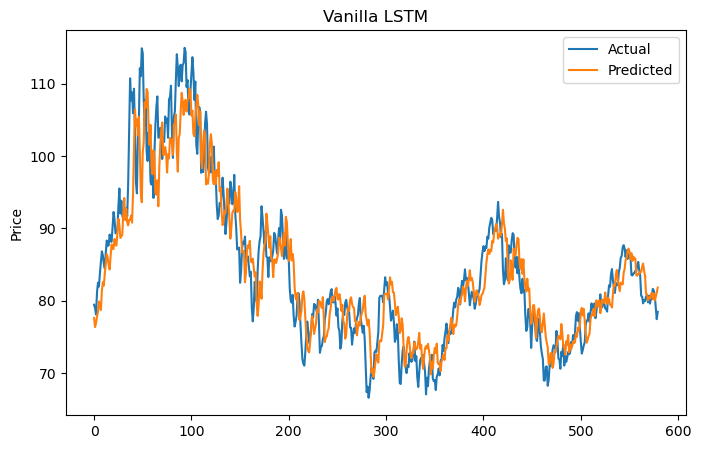

In [504]:
result_metrics_forecast(test_results['Actuals'], test_results['Test Predictions'],'Vanilla LSTM')

# Vanilla GRU model

In [249]:
def create_data_set(_data_set, _look_back):
    data_x, data_y = [], []
    for i in range(len(_data_set) - _look_back - 1):
        a = _data_set[i:(i + _look_back), 0]
        data_x.append(a)
        data_y.append(_data_set[i + _look_back, 0])
    return np.array(data_x), np.array(data_y)

look_back = 5
X_train,Y_train,X_test,Ytest, Xval, Yval = [],[],[],[],[], []

X_train,Y_train=create_data_set(train_sc,look_back)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
Y_train = Y_train.reshape(-1, 1)
print(X_train.shape, Y_train.shape)

X_test,Y_test=create_data_set(test_sc,look_back)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
Y_test = Y_test.reshape(-1, 1)
print(X_test.shape, Y_test.shape)

X_val,Y_val=create_data_set(validation_sc,look_back)
X_val = np.reshape(X_val, (X_val.shape[0], X_val.shape[1], 1))
Y_val = Y_val.reshape(-1, 1)
print(X_val.shape, Y_val.shape)

(4089, 5, 1) (4089, 1)
(580, 5, 1) (580, 1)
(1164, 5, 1) (1164, 1)


In [324]:
from keras.layers import GRU



# The GRU architecture
regressor_gru = Sequential()
# First GRU layer with Dropout regularisation
regressor_gru.add(GRU(units=60, return_sequences=True, input_shape=(X_train.shape[1],1), activation='tanh'))
regressor_gru.add(Dropout(0.1))
# Second GRU layer
regressor_gru.add(GRU(units=60, return_sequences=True, activation = 'tanh'))
regressor_gru.add(Dropout(0.1))
# The output layer
regressor_gru.add(Dense(units=1))
# Compiling the RNN
regressor_gru.compile(optimizer='adam',loss='mean_squared_error')
# Fitting to the training set
regressor_gru.fit(X_train, Y_train, epochs = 100, batch_size = 15,validation_data=(X_val,Y_val),shuffle=False)

epochs=range(len(loss)) # Get number of epochs
# Plot training and validation loss per epoch
plt.plot(epochs, loss, 'r',label='loss')
plt.plot(epochs,val_loss,'blue',label='val loss')
plt.title('Training loss & Val Loss by Epochs')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

plt.figure()

Epoch 1/100
273/273 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - loss: 0.0074 - val_loss: 0.0403
Epoch 2/100
273/273 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0062 - val_loss: 0.0476
Epoch 3/100
273/273 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - loss: 0.0058 - val_loss: 0.0362
Epoch 4/100
273/273 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - loss: 0.0043 - val_loss: 0.0235
Epoch 5/100
273/273 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - loss: 0.0032 - val_loss: 0.0147
Epoch 6/100
273/273 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0025 - val_loss: 0.0116
Epoch 7/100
273/273 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0022 - val_loss: 0.0104
Epoch 8/100
273/273 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - loss: 0.0021 - val_loss: 0.0116
Epoch 9/100
273/273 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0022 - val_loss: 0.0099
Epoch 10/100
273/273 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0021 - val_loss: 0.0094
Epoch 11/100
273/273 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0020 - val_loss: 0.0086
Epoch 12/100
273/273 ━━━━━━━━━━━━━━━━━━

KeyboardInterrupt: 

In [1]:
def get_predictions_val(X_val):
    
    val_predictions = regressor_gru.predict(X_val)
    val_predictions = scaler_val.inverse_transform(val_predictions[:,0]).flatten()
    Y_val_reverse = scaler_val.inverse_transform(Y_val).flatten()
    global val_results
    val_results = pd.DataFrame(data={ 'Val Predictions':val_predictions, 'Actuals':Y_val_reverse})
    return val_results

get_predictions_val(X_val).head(10)

NameError: name 'X_val' is not defined

Result Metrics for Vanilla GRU for validation data
R2 Score :  0.913
Mean Squared Error :  6.322
Mean Absolute Error :  1.953


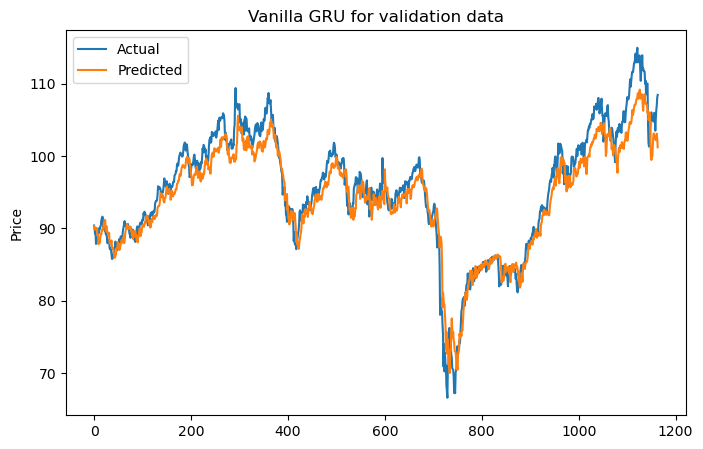

In [252]:
result_metrics_forecast(val_results['Actuals'], val_results['Val Predictions'],'Vanilla GRU for validation data')

In [253]:
def get_predictions_gru(X_test):
    
    test_predictions = regressor_gru.predict(X_test)
    test_predictions = scaler_test.inverse_transform(test_predictions[:,0]).flatten()
    Y_test_reverse = scaler_test.inverse_transform(Y_test).flatten()
    global test_results_gru
    test_results_gru = pd.DataFrame(data={ 'Test Predictions':test_predictions, 'Actuals':Y_test_reverse})
    return test_results_gru

get_predictions_gru(X_test).head(10)

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


,Test Predictions,Actuals
0,78.063995,79.47
1,76.802925,79.00
2,77.354836,78.11
3,78.208389,81.17
4,78.917381,82.51
5,80.336235,81.97
6,79.927353,83.82
7,79.158012,85.42
8,81.828354,86.84
9,83.016609,86.29


Result Metrics for Vanilla GRU
R2 Score :  0.841
Mean Squared Error :  19.541
Mean Absolute Error :  3.28


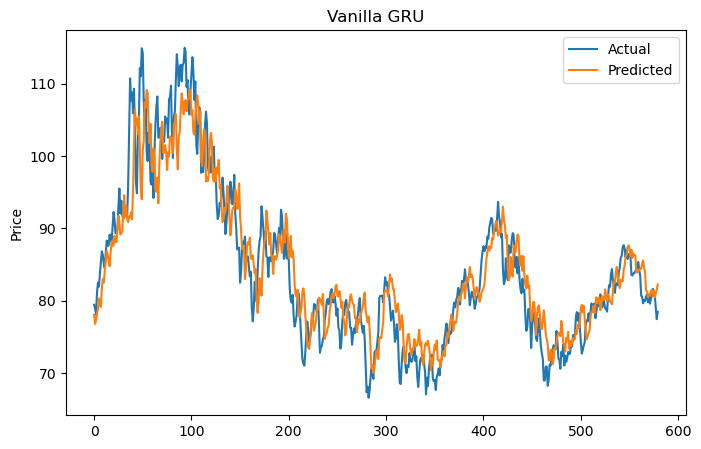

In [254]:
result_metrics_forecast(test_results_gru['Actuals'], test_results_gru['Test Predictions'],'Vanilla GRU')

In [255]:
print('Test Mean Absolute Error:', mean_absolute_error(test_results['Test Predictions'], test_results['Actuals']))
print('Test Root Mean Squared Error:',np.sqrt(mean_squared_error(test_results['Test Predictions'], test_results['Actuals'])))

Test Mean Absolute Error: 3.2468065780113484
Test Root Mean Squared Error: 4.394239583475993


In [256]:
#Test Mean Absolute Error: 4.6751689198308295
#Test Root Mean Squared Error: 5.595224578344109

# Univariate CNN model

In [20]:
def postprocess_p_gru(arr):
  arr = (arr* (wti_test_max4 - wti_test_min4)) + wti_test_min4
  return arr

In [21]:
def create_data_set(_data_set, _look_back):
    data_x, data_y = [], []
    for i in range(len(_data_set) - _look_back - 1):
        a = _data_set[i:(i + _look_back), 0]
        data_x.append(a)
        data_y.append(_data_set[i + _look_back, 0])
    return np.array(data_x), np.array(data_y)

look_back = 5
X_train,Y_train,X_test,Ytest, Xval, Yval = [],[],[],[],[], []

X_train,Y_train=create_data_set(train_sc,look_back)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
Y_train = Y_train.reshape(-1, 1)
print(X_train.shape, Y_train.shape)

X_test,Y_test=create_data_set(test_sc,look_back)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
Y_test = Y_test.reshape(-1, 1)
print(X_test.shape, Y_test.shape)

X_val,Y_val=create_data_set(validation_sc,look_back)
X_val = np.reshape(X_val, (X_val.shape[0], X_val.shape[1], 1))
Y_val = Y_val.reshape(-1, 1)
print(X_val.shape, Y_val.shape)

(4280, 5, 1) (4280, 1)
(608, 5, 1) (608, 1)
(1218, 5, 1) (1218, 1)


Epoch 1/100
286/286 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.0170 - val_loss: 0.2228
Epoch 2/100
286/286 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0091 - val_loss: 0.1590
Epoch 3/100
286/286 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0069 - val_loss: 0.1001
Epoch 4/100
286/286 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0047 - val_loss: 0.0586
Epoch 5/100
286/286 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0032 - val_loss: 0.0420
Epoch 6/100
286/286 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0023 - val_loss: 0.0303
Epoch 7/100
286/286 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0018 - val_loss: 0.0254
Epoch 8/100
286/286 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0015 - val_loss: 0.0244
Epoch 9/100
286/286 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0013 - val_loss: 0.0248
Epoch 10/100
286/286 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0012 - val_loss: 0.0263
Epoch 11/100
286/286 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0012 - val_loss: 0.0283
Epoch 12/100
286/286 ━━━━━━━━━━━━━━━━━━━━

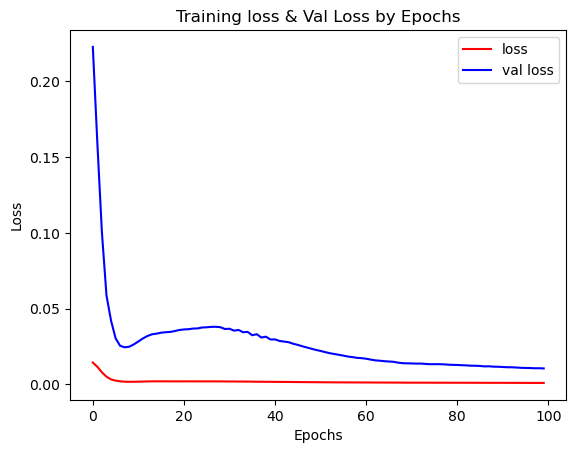

<Figure size 640x480 with 0 Axes>

In [22]:


from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.optimizers import Adam
from keras.callbacks import EarlyStopping


model_cnn = Sequential()
model_cnn.add(Conv1D(filters=49, kernel_size=2, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2])))

model_cnn.add(MaxPooling1D(pool_size=2))

model_cnn.add(Flatten())

model_cnn.add(Dense(50, activation='sigmoid'))

model_cnn.add(Dense(1))
model_cnn.compile(loss='mse', optimizer='Adam')
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=50)

history_simple_1 = model_cnn.fit(X_train, Y_train, validation_data=(X_val, Y_val), epochs = 100, batch_size = 15, shuffle=False, callbacks=[es])


loss=history_simple_1.history['loss']
val_loss = history_simple_1.history['val_loss']


epochs=range(len(loss)) # Get number of epochs
# Plot training and validation loss per epoch
plt.plot(epochs, loss, 'r',label='loss')
plt.plot(epochs,val_loss,'blue',label='val loss')
plt.title('Training loss & Val Loss by Epochs')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

plt.figure()
#model_cnn.summary()

def plot_predictions_final_cnn(model, X, y):
  predictions = model.predict(X)
  wti_preds = postprocess_p_gru(predictions[:,0])
  actuals = postprocess_p_gru(y4_test)
  global df2
  df2 = pd.DataFrame(data={
                          'WTI Actuals': actuals.flatten(),
                          'WTI Predictions': wti_preds.flatten(),
                          })
  plt.plot(df2['WTI Actuals'])
  plt.plot(df2['WTI Predictions'])
  plt.title('Multivariate CNN model')
  plt.ylabel('Price')
  fig = plt.figure(figsize=(8,5))
  return df2

In [35]:
def get_predictions_val(X_val):
    
    val_predictions = model_cnn.predict(X_val)
    val_predictions = scaler_val.inverse_transform(val_predictions).flatten()
    Y_val_reverse = scaler_val.inverse_transform(Y_val).flatten()
    global val_results
    val_results = pd.DataFrame(data={ 'Val Predictions':val_predictions, 'Actuals':Y_val_reverse})
    return val_results

get_predictions_val(X_val).head(10)

39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


,Val Predictions,Actuals
0,41.964241,53.81
1,41.819805,53.01
2,41.730427,52.19
3,41.238842,52.37
4,40.263260,52.99
5,40.693481,53.84
6,41.868862,52.96
7,41.812782,53.21
8,41.282974,53.11
9,41.107113,53.41


Result Metrics for Vanilla CNN for validation data
R2 Score :  0.049
Mean Squared Error :  157.108
Mean Absolute Error :  12.262


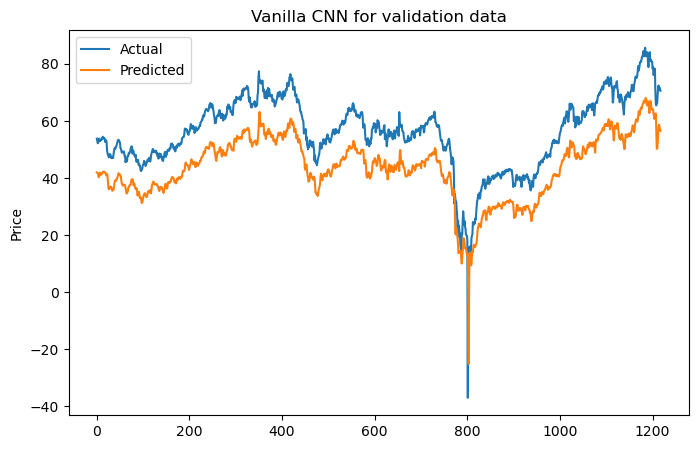

In [36]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
result_metrics_forecast(val_results['Actuals'], val_results['Val Predictions'],'Vanilla CNN for validation data')

In [32]:
def get_predictions_cnn(X_test):
    
    test_predictions = model_cnn.predict(X_test)
    test_predictions = scaler_test.inverse_transform(test_predictions).flatten()
    Y_test_reverse = scaler_test.inverse_transform(Y_test).flatten()
    global test_results_cnn
    test_results_cnn = pd.DataFrame(data={ 'Test Predictions':test_predictions, 'Actuals':Y_test_reverse})
    return test_results_cnn

get_predictions_cnn(X_test).head(10)

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


,Test Predictions,Actuals
0,69.613792,73.89
1,71.153069,75.49
2,72.838638,76.01
3,74.414658,76.58
4,75.033432,76.83
5,75.568146,75.33
6,75.020668,75.99
7,74.289642,77.00
8,74.968224,77.83
9,76.413033,79.47


In [33]:
def result_metrics_forecast(test_series,forecast_series,model_name):
  print('Result Metrics for ' +  str(model_name))
  print('R2 Score : ',round(r2_score(test_series,forecast_series),3))
  print('Mean Squared Error : ',round(mean_squared_error(test_series,forecast_series),3))
  print('Mean Absolute Error : ',round(mean_absolute_error(test_series,forecast_series),3))
  fig = plt.figure(figsize=(8,5))
  plt.plot(test_series,label='Actual')
  plt.plot(forecast_series,label='Predicted')
  plt.title(str(model_name))
  plt.ylabel('Price')
  plt.legend()

Result Metrics for Vanilla CNN
R2 Score :  0.92
Mean Squared Error :  12.084
Mean Absolute Error :  2.575


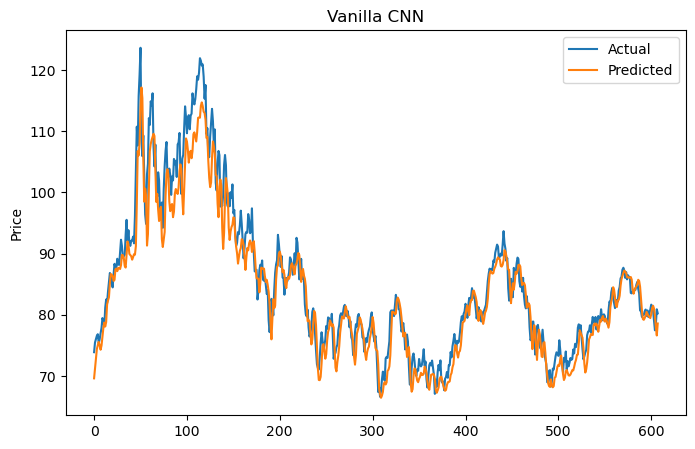

In [34]:
result_metrics_forecast(test_results_cnn['Actuals'], test_results_cnn['Test Predictions'],'Vanilla CNN')